## Materyal

Bu proje kapsamında kullanılan veri seti, **"Türkçe Sosyal Medya Paylaşım Veri Seti"** olarak adlandırılmaktadır. Veri seti, sosyal medya platformlarından toplanan Türkçe metinlerden oluşmaktadır. Amaç, sosyal medya paylaşımlarında **saldırganlık**, **nefret söylemi** veya **olumlu/olumsuz duygu analizi** gibi durumları analiz edebilecek bir makine öğrenmesi modeli geliştirmektir.

Veri seti **11119 satırdan** ve **2 sütundan** oluşmaktadır:
- `Tip`: Paylaşımın duygusal sınıfı ("Pozitif" veya "Negatif"),
- `Paylaşım`: Paylaşımın kendisi (metin).

Veri anonimleştirilmiş sosyal medya verileri üzerinden oluşturulmuş olup, eğitim ve araştırma amaçlı kullanılmaktadır.


In [19]:
# Veri işleme
import pandas as pd
import numpy as np

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Makine öğrenmesi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Metin temizleme
import re

In [50]:
# Veri setini yükleyelim
try:
    df = pd.read_csv("newcsv.csv", encoding='utf-8-sig', quotechar='"', engine="python")
except UnicodeDecodeError:
    df = pd.read_csv("newcsv.csv", encoding='ISO-8859-9', quotechar='"', engine="python")


# Veri setinin ilk birkaç satırına göz atalım
df.head()

# Veri seti hakkında genel bilgiler
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11119 entries, 0 to 11118
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tip       11119 non-null  object
 1   Paylaşım  11117 non-null  object
dtypes: object(2)
memory usage: 173.9+ KB
None


In [21]:
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11119 entries, 0 to 11118
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tip       11119 non-null  object
 1   Paylaşım  11117 non-null  object
dtypes: object(2)
memory usage: 173.9+ KB


,Tip,Paylaşım
count,11119,11117
unique,2,11005
top,Pozitif,seni öldürürüm
freq,6115,3


### Describe Yorumları:
- `Tip` sütununda 2 farklı sınıf var: "Pozitif" ve "Negatif".
- Pozitif sınıfı 6115 örnek ile veri setinde çoğunlukta.
- `Paylaşım` sütununda 11005 farklı metin var, bazı tekrar eden veriler mevcut.
- `Paylaşım` sütununda 2 eksik kayıt bulunmaktadır.


In [22]:
# Eksik veri kontrolü
df.isnull().sum()


,0
Tip,0
Paylaşım,2


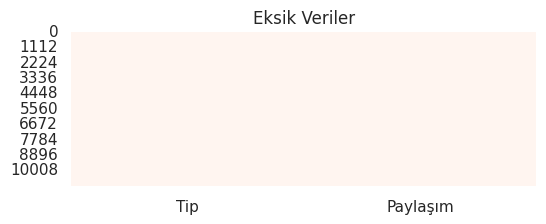

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 2))
sns.heatmap(df.isnull(), cbar=False, cmap="Reds")
plt.title("Eksik Veriler")
plt.show()


In [24]:
df = df.dropna(subset=['Paylaşım'])


In [25]:
df.isnull().sum()


,0
Tip,0
Paylaşım,0


In [26]:
df['Tip'].value_counts()


,count
Tip,
Pozitif,6113
Negatif,5004


In [27]:
df.loc[:, 'Tip'] = df['Tip'].str.lower().str.capitalize()


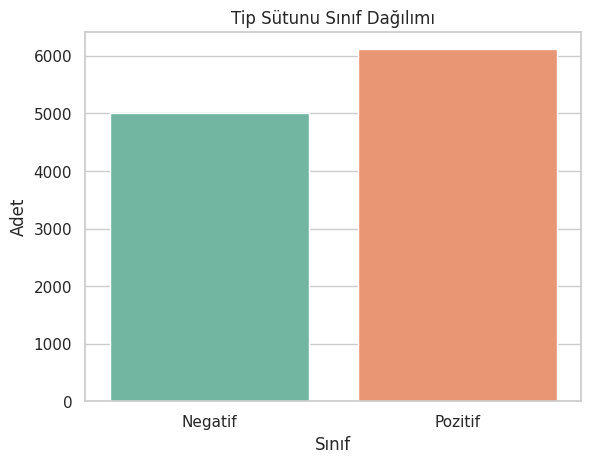

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Tip', hue='Tip', palette='Set2', legend=False)
plt.title("Tip Sütunu Sınıf Dağılımı")
plt.xlabel("Sınıf")
plt.ylabel("Adet")
plt.show()


### Ayrık Veri Analizi Sonuçları:

- `Tip` sütununda iki sınıf olduğu görülüyor: "Pozitif" ve "Negatif".
- Sınıf dağılımı dengesiz olabilir. Bu durum bazı algoritmalar için önemli olabilir (örneğin: F1-score tercih sebebi olabilir).
- Verilerde küçük/büyük harf farkı giderildi ve tek tip hale getirildi.


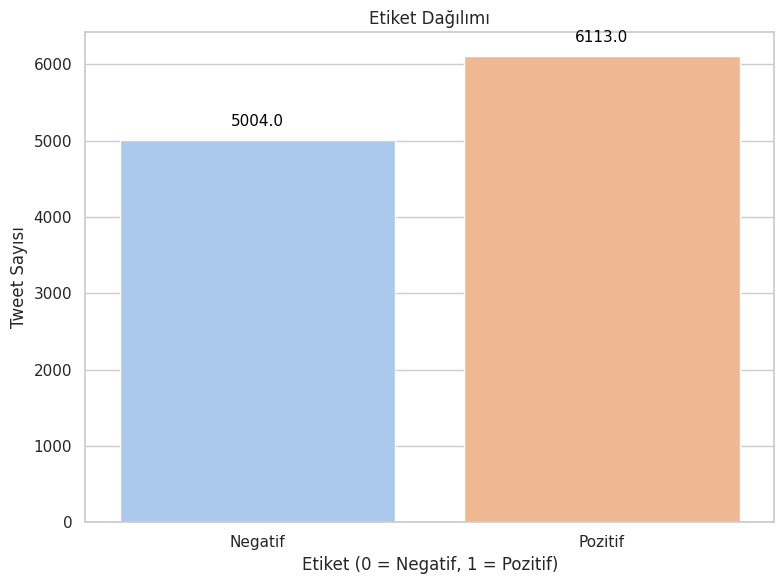

In [29]:
# Etiket dağılımı
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Tip', data=df, palette='pastel', hue='Tip')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 8), textcoords='offset points')
plt.title("Etiket Dağılımı")
plt.xlabel("Etiket (0 = Negatif, 1 = Pozitif)")
plt.ylabel("Tweet Sayısı")
plt.tight_layout()
plt.show()

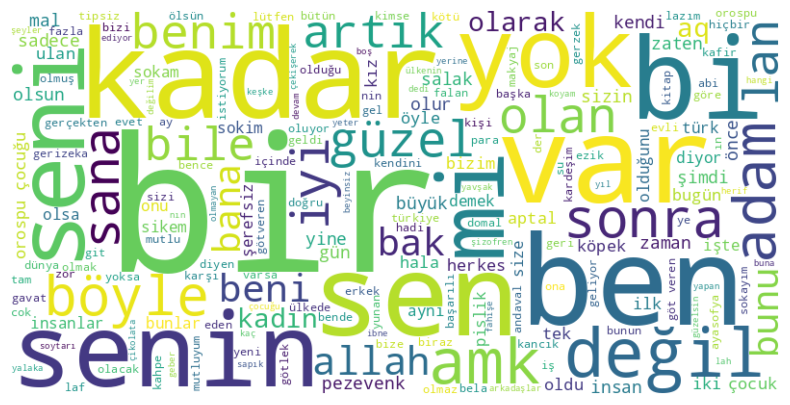

In [30]:
# Kelime bulutu
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['Paylaşım']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [31]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['Paylaşım'])
y = df['Tip']

# En iyi 500 özelliği seçelim
from sklearn.feature_selection import SelectKBest, chi2
X_new = SelectKBest(chi2, k=500).fit_transform(X, y)



In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)



In [33]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


--- Logistic Regression ---
Confusion Matrix:
[[ 724  283]
 [  89 1128]]
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.89      0.72      0.80      1007
     Pozitif       0.80      0.93      0.86      1217

    accuracy                           0.83      2224
   macro avg       0.84      0.82      0.83      2224
weighted avg       0.84      0.83      0.83      2224

--- Random Forest ---
Confusion Matrix:
[[ 742  265]
 [ 147 1070]]
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.83      0.74      0.78      1007
     Pozitif       0.80      0.88      0.84      1217

    accuracy                           0.81      2224
   macro avg       0.82      0.81      0.81      2224
weighted avg       0.82      0.81      0.81      2224

--- SVM ---
Confusion Matrix:
[[ 739  268]
 [  85 1132]]
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.90  

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# F1 skorunu string sınıflarla çalışacak şekilde ayarlayalım
f1_scorer = make_scorer(f1_score, pos_label='Pozitif')

# Hiperparametre grid'leri
param_grid_lr = {'C': [0.1, 1, 10]}
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [None, 10]}
param_grid_svc = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

grids = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), param_grid_lr),
    "Random Forest": (RandomForestClassifier(), param_grid_rf),
    "SVM": (SVC(), param_grid_svc)
}

best_models = {}

for name, (model, params) in grids.items():
    grid = GridSearchCV(model, params, cv=5, scoring=f1_scorer)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    print(f"{name} için en iyi parametreler: {grid.best_params_}")
    print(f"{name} için en iyi F1 skoru: {grid.best_score_:.4f}")

    if name == "Logistic Regression":
        print(f"Logistic Regression için en iyi C değeri: {grid.best_params_['C']}")
    elif name == "Random Forest":
        print(f"Random Forest için en iyi n_estimators: {grid.best_params_['n_estimators']}, max_depth: {grid.best_params_['max_depth']}")
    elif name == "SVM":
        print(f"SVM için en iyi C değeri: {grid.best_params_['C']}, kernel: {grid.best_params_['kernel']}")

    print("="*50)


Logistic Regression için en iyi parametreler: {'C': 10}
Logistic Regression için en iyi F1 skoru: 0.8724
Logistic Regression için en iyi C değeri: 10
Random Forest için en iyi parametreler: {'max_depth': None, 'n_estimators': 100}
Random Forest için en iyi F1 skoru: 0.8442
Random Forest için en iyi n_estimators: 100, max_depth: None
SVM için en iyi parametreler: {'C': 1, 'kernel': 'rbf'}
SVM için en iyi F1 skoru: 0.8697
SVM için en iyi C değeri: 1, kernel: rbf


In [17]:
# Hiperparametre optimizasyonu
from sklearn.model_selection import GridSearchCV

# Logistic Regression için
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='f1_macro')
grid_lr.fit(X_train, y_train)

# Random Forest için
param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='f1_macro')
grid_rf.fit(X_train, y_train)

# SVM için
param_grid_svc = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, scoring='f1_macro')
grid_svc.fit(X_train, y_train)

# Final modellerle değerlendirme
from sklearn.metrics import classification_report, confusion_matrix

final_models = {
    "Logistic Regression": grid_lr.best_estimator_,
    "Random Forest": grid_rf.best_estimator_,
    "SVM": grid_svc.best_estimator_
}

for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n--- {name} ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Friedman testi ile istatistiksel karşılaştırma
from sklearn.model_selection import cross_val_score
from scipy.stats import friedmanchisquare

lr_scores = cross_val_score(grid_lr.best_estimator_, X_train, y_train, cv=5, scoring='f1_macro')
rf_scores = cross_val_score(grid_rf.best_estimator_, X_train, y_train, cv=5, scoring='f1_macro')
svc_scores = cross_val_score(grid_svc.best_estimator_, X_train, y_train, cv=5, scoring='f1_macro')

stat, p = friedmanchisquare(lr_scores, rf_scores, svc_scores)
print(f"\nFriedman Testi Sonucu: p-değeri = {p:.4f}")
if p < 0.05:
    print("Anlamlı fark var: Algoritmalar istatistiksel olarak farklı.")
else:
    print("Anlamlı fark yok.")



--- Logistic Regression ---
Confusion Matrix:
[[ 747  260]
 [  91 1126]]
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.89      0.74      0.81      1007
     Pozitif       0.81      0.93      0.87      1217

    accuracy                           0.84      2224
   macro avg       0.85      0.83      0.84      2224
weighted avg       0.85      0.84      0.84      2224


--- Random Forest ---
Confusion Matrix:
[[ 747  260]
 [ 140 1077]]
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.84      0.74      0.79      1007
     Pozitif       0.81      0.88      0.84      1217

    accuracy                           0.82      2224
   macro avg       0.82      0.81      0.82      2224
weighted avg       0.82      0.82      0.82      2224


--- SVM ---
Confusion Matrix:
[[ 746  261]
 [  91 1126]]
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.8

In [18]:
from sklearn.metrics import make_scorer, f1_score

# Pozitif sınıfı belirterek özel bir scorer tanımlıyoruz
f1_scorer = make_scorer(f1_score, pos_label='Pozitif')

# Her model için çapraz doğrulama f1 skorlarını hesaplıyoruz
for name, model in best_models.items():
    scores = cross_val_score(model, X_new, y, cv=5, scoring=f1_scorer)
    print(f"{name} çapraz doğrulama F1 skoru ortalama: {np.mean(scores):.4f}")


Logistic Regression çapraz doğrulama F1 skoru ortalama: 0.8408
Random Forest çapraz doğrulama F1 skoru ortalama: 0.8084
SVM çapraz doğrulama F1 skoru ortalama: 0.8402


In [35]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel, wilcoxon

# f1 skorunu, 'Pozitif' sınıfı pozitif sınıf olarak belirterek tanımla
f1_scorer = make_scorer(f1_score, pos_label='Pozitif')

# Logistic Regression ve Random Forest için F1 skorlarını yeniden hesapla
scores_lr = cross_val_score(best_models["Logistic Regression"], X_new, y, cv=5, scoring=f1_scorer)
scores_rf = cross_val_score(best_models["Random Forest"], X_new, y, cv=5, scoring=f1_scorer)

# Paired t-testi
t_stat, p_value = ttest_rel(scores_lr, scores_rf)
print(f"Logistic Regression ve Random Forest arasında Paired t-testi: p-değeri = {p_value}")

# Wilcoxon testi
w_stat, p_value_w = wilcoxon(scores_lr, scores_rf)
print(f"Logistic Regression ve Random Forest arasında Wilcoxon testi: p-değeri = {p_value_w}")


Logistic Regression ve Random Forest arasında Paired t-testi: p-değeri = 0.0013661322284673082
Logistic Regression ve Random Forest arasında Wilcoxon testi: p-değeri = 0.0625


In [87]:
y_train_pred = best_models["Logistic Regression"].predict(X_train)
print("En İyi Model (Eğitim Seti) Sınıflandırma Raporu:")
print(classification_report(y_train, y_train_pred))

y_test_pred = best_models["Logistic Regression"].predict(X_test)
print("En İyi Model (Test Seti) Sınıflandırma Raporu:")
print(classification_report(y_test, y_test_pred))


En İyi Model (Eğitim Seti) Sınıflandırma Raporu:
              precision    recall  f1-score   support

     Negatif       0.91      0.78      0.84      3997
     Pozitif       0.84      0.94      0.88      4896

    accuracy                           0.87      8893
   macro avg       0.87      0.86      0.86      8893
weighted avg       0.87      0.87      0.86      8893

En İyi Model (Test Seti) Sınıflandırma Raporu:
              precision    recall  f1-score   support

     Negatif       0.89      0.74      0.81      1007
     Pozitif       0.81      0.93      0.87      1217

    accuracy                           0.84      2224
   macro avg       0.85      0.83      0.84      2224
weighted avg       0.85      0.84      0.84      2224



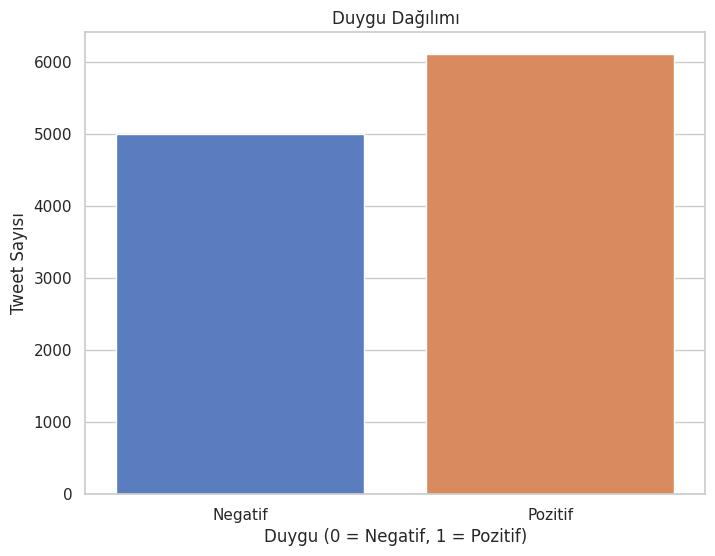

In [37]:
# Grafik için düzenlemeleri yapıyoruz
plt.figure(figsize=(8, 6))

# Hue parametresi eklenmiş versiyon
sns.countplot(x='Tip', data=df, hue='Tip', palette='muted', legend=False)

plt.title("Duygu Dağılımı")
plt.xlabel("Duygu (0 = Negatif, 1 = Pozitif)")
plt.ylabel("Tweet Sayısı")
plt.show()


Pozitif tweet sayısı: 6113
Negatif tweet sayısı: 5004


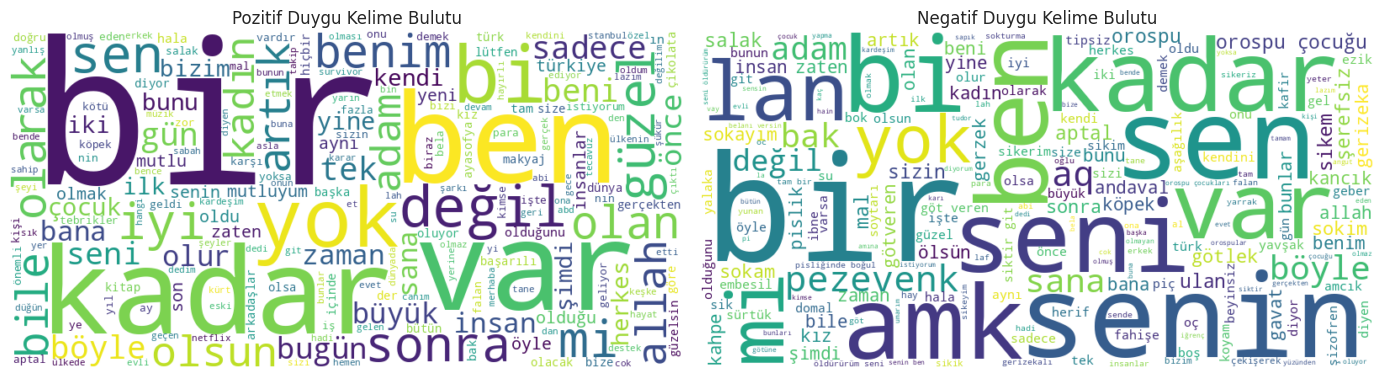

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 'Paylasim' yerine 'Paylaşım' kullanılacak şekilde uyumlu hale getirdik
if 'Paylasim' in df.columns and 'Paylaşım' not in df.columns:
    df.rename(columns={'Paylasim': 'Paylaşım'}, inplace=True)

# Eksik verileri temizledik
df = df.dropna(subset=['Paylaşım', 'Tip'])

# Tip sütununu sayıya çevirdik ('Pozitif' → 1, 'Negatif' → 0)
df['Tip'] = df['Tip'].map({'Pozitif': 1, 'Negatif': 0})

# Pozitif ve negatif tweet'leri filtrele
positive_tweets = df[df['Tip'] == 1]
negative_tweets = df[df['Tip'] == 0]

print(f"Pozitif tweet sayısı: {len(positive_tweets)}")
print(f"Negatif tweet sayısı: {len(negative_tweets)}")

# Kelime bulutlarını oluşturduk ve görselleştirdik
if len(positive_tweets) > 0 and len(negative_tweets) > 0:
    positive_words = " ".join(positive_tweets['Paylaşım'].astype(str))
    negative_words = " ".join(negative_tweets['Paylaşım'].astype(str))

    positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_words)
    negative_wc = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(positive_wc, interpolation='bilinear')
    axes[0].axis("off")
    axes[0].set_title("Pozitif Duygu Kelime Bulutu")
    axes[1].imshow(negative_wc, interpolation='bilinear')
    axes[1].axis("off")
    axes[1].set_title("Negatif Duygu Kelime Bulutu")
    plt.tight_layout()
    plt.show()
else:
    print("Pozitif veya negatif tweet verisi bulunamadı.")




In [40]:
missing = df.isnull().sum()
df.fillna(df.mean(numeric_only=True), inplace=True)

In [41]:
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

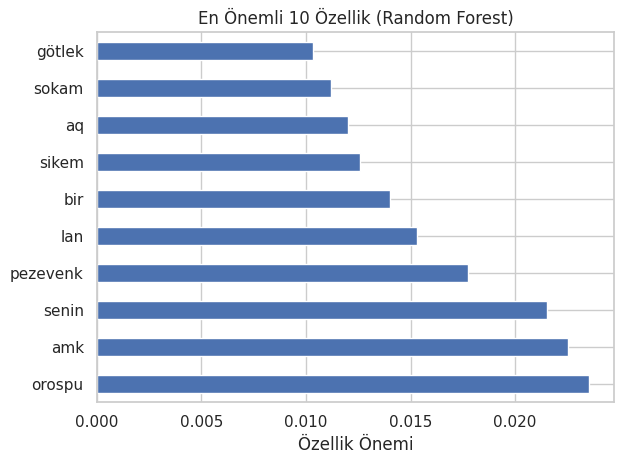

In [42]:
# X, TF-IDF veya başka bir vektörleştiriciden geliyorsa, onu DataFrame'e dönüştürelim
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Random Forest modelini eğitelim
rf = RandomForestClassifier()
rf.fit(X_df, y)

# Özellik önemlerini alalım
importances = pd.Series(rf.feature_importances_, index=X_df.columns)

# En yüksek 10 özelliği görselleştirelim
importances.nlargest(10).plot(kind='barh')
plt.title("En Önemli 10 Özellik (Random Forest)")
plt.xlabel("Özellik Önemi")
plt.tight_layout()
plt.show()


<ipython-input-51-9e1a213abb59>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette="viridis")


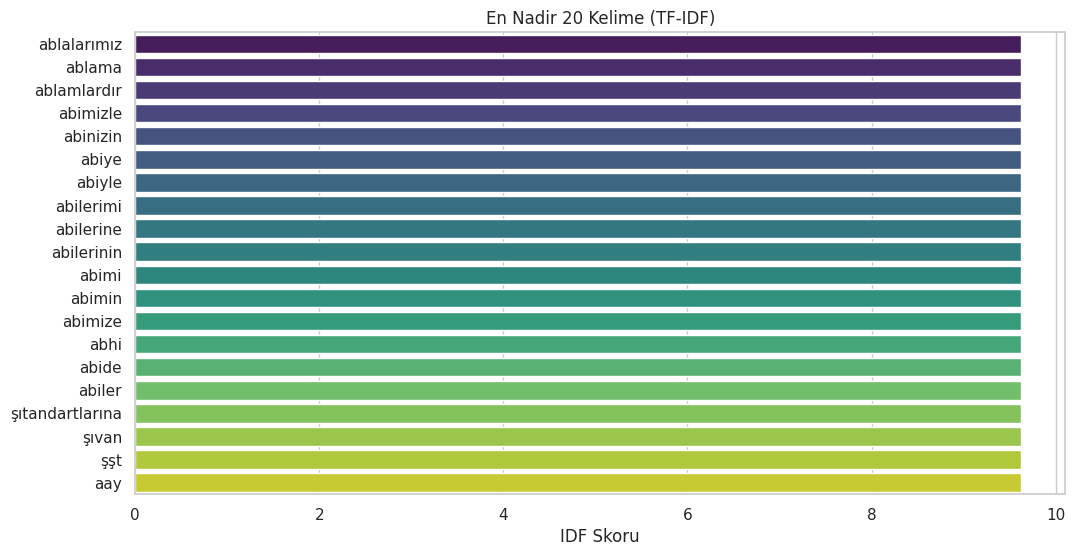

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sadece dolu olan "Paylaşım" verilerini al
corpus = df['Paylaşım'].dropna().astype(str).tolist()

# TF-IDF hesapla
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

# Özellik isimleri ve IDF skorları
feature_names = vectorizer.get_feature_names_out()
idf_scores = vectorizer.idf_

# En yüksek IDF (en nadir) 20 kelimeyi seç
top_n = 20
sorted_idx = np.argsort(idf_scores)[-top_n:]
top_words = feature_names[sorted_idx]
top_scores = idf_scores[sorted_idx]

# Görselleştir
plt.figure(figsize=(12, 6))
sns.barplot(x=top_scores, y=top_words, palette="viridis")
plt.xlabel("IDF Skoru")
plt.title(f"En Nadir {top_n} Kelime (TF-IDF)")
plt.show()





In [52]:
from sklearn.model_selection import GridSearchCV
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [None, 10]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10], 'n_estimators': [50, 100]},
             scoring='accuracy')

In [53]:
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel
scores_rf = cross_val_score(RandomForestClassifier(), X, y, cv=5)
scores_svm = cross_val_score(SVC(), X, y, cv=5)
t_stat, p_value = ttest_rel(scores_rf, scores_svm)

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = grid_rf.predict(X_test)
confusion_matrix(y_test, y_pred)
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n     Negatif       0.84      0.74      0.79      1007\n     Pozitif       0.80      0.88      0.84      1217\n\n    accuracy                           0.82      2224\n   macro avg       0.82      0.81      0.81      2224\nweighted avg       0.82      0.82      0.82      2224\n'

In [ ]:
# Soru 1: Negatif içerikli sosyal medya paylaşımları, belirli temalar (şiddet, öfke, hakaret vb.) etrafında kümelenebilir mi?
# Bu analizde, negatif olarak etiketlenmiş sosyal medya metinleri üzerinde konu modelleme (LDA) uygulanacaktır.
# Amaç, hangi içeriklerin baskın temalar etrafında toplandığını gözlemlemektir.

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vektörleştirme (temiz metinler)
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')  # <- bu satır düzeltildi
X = vectorizer.fit_transform(negatif_df['Paylaşım'].astype(str))

# LDA uygulama
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X)

# Temaları yazdıralım
feature_names = vectorizer.get_feature_names_out()
for index, topic in enumerate(lda.components_):
    print(f"Küme {index+1}: ", [feature_names[i] for i in topic.argsort()[-6:][::-1]])



Küme 1:  ['sen', 'bir', 'amk', 'lan', 'bi', 'var']
Küme 2:  ['bir', 'orospu', 'seni', 'bi', 'sen', 'senin']
Küme 3:  ['senin', 'bir', 'allah', 'kadar', 'seni', 'lan']


In [ ]:
# Soru 2: Pozitif ve negatif paylaşımlar arasında sözcük çeşitliliği (vocabulary richness) açısından anlamlı bir fark var mıdır?
# Burada Type-Token Ratio (benzersiz kelime sayısı / toplam kelime sayısı) karşılaştırılacaktır.
# İstatistiksel anlamlılık için t-testi uygulanacaktır.

In [58]:
# Her paylaşımın kelime çeşitliliğini (TTR) hesaplayalım
def calculate_ttr(text):
    tokens = str(text).split()
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / len(tokens)

df['TTR'] = df['Paylaşım'].apply(calculate_ttr)


Pozitif ortalama TTR: 0.977
Negatif ortalama TTR: 0.981
p-değeri: 0.0001


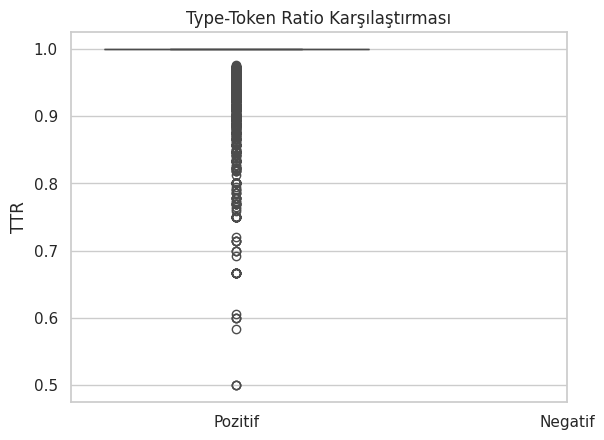

In [59]:
from scipy.stats import ttest_ind
import seaborn as sns

# Pozitif ve negatif TTR değerlerini alalım
pozitif_TTR = df[df['Tip'] == 'Pozitif']['TTR']
negatif_TTR = df[df['Tip'] == 'Negatif']['TTR']

# t-testi
ttr_test = ttest_ind(pozitif_TTR.dropna(), negatif_TTR.dropna())
print(f"Pozitif ortalama TTR: {pozitif_TTR.mean():.3f}")
print(f"Negatif ortalama TTR: {negatif_TTR.mean():.3f}")
print(f"p-değeri: {ttr_test.pvalue:.4f}")

# Görselleştirme
sns.boxplot(data=[pozitif_TTR, negatif_TTR])
plt.xticks([0, 1], ['Pozitif', 'Negatif'])
plt.title("Type-Token Ratio Karşılaştırması")
plt.ylabel("TTR")
plt.show()


In [77]:
# Soru 3: Negatif paylaşımlar, pozitiflere göre daha kısa cümle yapısına mı sahiptir?
# Her paylaşımın kelime sayısı ölçülüp, iki grup karşılaştırılacaktır. T-testi ile anlamlılık incelenecektir.

In [61]:
# Her paylaşım için kelime sayısı hesaplayalım
df["kelime_sayisi"] = df["Paylaşım"].apply(lambda x: len(str(x).split()))


Pozitif ortalama uzunluk: 10.55
Negatif ortalama uzunluk: 9.51
p-değeri: 0.0000


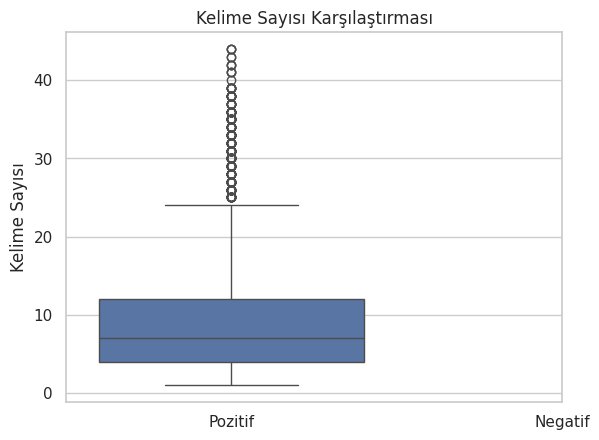

In [62]:
# Kelime sayısı karşılaştırmasını yapalım
pozitif_len = df[df['Tip'] == 'Pozitif']['kelime_sayisi']
negatif_len = df[df['Tip'] == 'Negatif']['kelime_sayisi']

length_test = ttest_ind(pozitif_len.dropna(), negatif_len.dropna())
print(f"Pozitif ortalama uzunluk: {pozitif_len.mean():.2f}")
print(f"Negatif ortalama uzunluk: {negatif_len.mean():.2f}")
print(f"p-değeri: {length_test.pvalue:.4f}")

# Görselleştirelim
sns.boxplot(data=[pozitif_len, negatif_len])
plt.xticks([0, 1], ['Pozitif', 'Negatif'])
plt.title("Kelime Sayısı Karşılaştırması")
plt.ylabel("Kelime Sayısı")
plt.show()


In [76]:
# Genişletilmiş Tematik Sınıflandırma
# Negatif duygulu sosyal medya paylaşımlarının içeriklerine göre aşağıdaki tematik kategorilere atama yapıyoruz:
# - Kadına Şiddet ve Cinsiyetçilik
# - Bireysel Hakaret ve Zorbalık
# - Dini ve Milli Değerlere Saldırı
# - Toplumsal Eleştiri ve Güvensizlik
# - Psikolojik Çöküntü ve Umutsuzluk
# - Hayvan Üzerinden Hakaret/Şiddet
# - Cinsel İma ve Küfür
# - Alaycı Mizah ve Vulgarlık
# Her kategori belirli anahtar kelimelerle eşleştirilir. Paylaşımların içeriklerinde bu kelimeler aranır.

In [63]:
# Kategorik anahtar kelimeleri
kategori_kelimeleri = {
    "Kadına Şiddet ve Cinsiyetçilik": ['kadın', 'karı', 'orospu', 'namus', 'tecavüz', 'iffet', 'kadınca'],
    "Bireysel Hakaret ve Zorbalık": ['salak', 'aptal', 'şerefsiz', 'lan', 'beyinsiz', 'geri zekalı', 'dangalak', 'mal'],
    "Dini ve Milli Değerlere Saldırı": ['allah', 'din', 'şeriat', 'müslüman', 'imam', 'vatan', 'millet', 'ezan'],
    "Psikolojik Çöküntü ve Umutsuzluk": ['ölüm', 'intihar', 'dayanamıyorum', 'bittim', 'nefret ediyorum', 'iğrenç', 'hayat'],
    "Hayvan Üzerinden Hakaret/Şiddet": ['köpek', 'eşek', 'hayvan', 'sıç', 'ısır', 'öldür'],
    "Alaycı Mizah ve Vulgarlık": ['ağzına sıçayım', 'haha', 'dalga geç', 'komik', 'neye güldüm']
}


In [64]:
# Kategori atama fonksiyonu
def kategori_bul(metin):
    metin = str(metin).lower()
    kategoriler = []
    for kategori, kelimeler in kategori_kelimeleri.items():
        if any(anahtar in metin for anahtar in kelimeler):
            kategoriler.append(kategori)
    return kategoriler if kategoriler else ['Diğer']

# Sadece negatif paylaşımları alıyoruz
negatif_df = df[df['Tip'] == 'Negatif'].copy()
negatif_df['Kategoriler'] = negatif_df['Paylaşım'].apply(kategori_bul)

# Kategorilere göre explode işlemi
kategori_df = negatif_df.explode('Kategoriler')


<ipython-input-65-66bc9b79f655>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kategori_sayim.values, y=kategori_sayim.index, palette="magma")


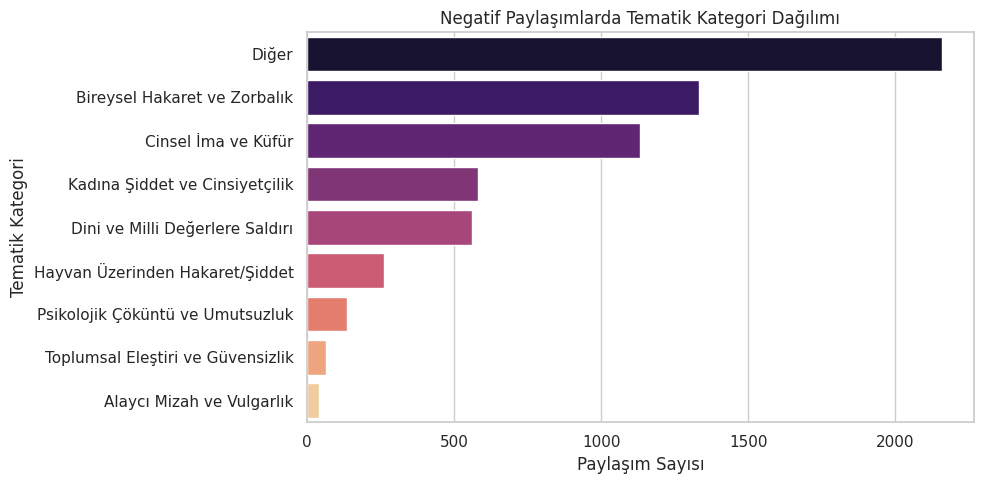

In [65]:
# Kategori frekanslarını hesaplıyoruz
kategori_sayim = kategori_df['Kategoriler'].value_counts()

# Görselleştirme
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(x=kategori_sayim.values, y=kategori_sayim.index, palette="magma")
plt.title("Negatif Paylaşımlarda Tematik Kategori Dağılımı")
plt.xlabel("Paylaşım Sayısı")
plt.ylabel("Tematik Kategori")
plt.tight_layout()
plt.show()


In [66]:
# Her kategori için örnek paylaşım çekelim
ornekler = kategori_df.groupby("Kategoriler").apply(lambda x: x['Paylaşım'].sample(1).values[0])
display(ornekler)


<ipython-input-66-90e4d78ce144>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ornekler = kategori_df.groupby("Kategoriler").apply(lambda x: x['Paylaşım'].sample(1).values[0])


,0
Kategoriler,
Alaycı Mizah ve Vulgarlık,kancık beyaztv ekibi iş başında akıllarınca da...
Bireysel Hakaret ve Zorbalık,gerizekali amciklar sizce kralicemizin cembari...
Cinsel İma ve Küfür,we are turkish orospu çocuğu sikerim belanı
Dini ve Milli Değerlere Saldırı,vicdansız allah senin belanı versin
Diğer,mehmet metiner tarihte şahsiyet var doğrusu bi...
Hayvan Üzerinden Hakaret/Şiddet,devletime cumhurbaşkanıma bayrağıma halkına se...
Kadına Şiddet ve Cinsiyetçilik,gerçekten orospu çocuğu adi aşağılık herif hak...
Psikolojik Çöküntü ve Umutsuzluk,aptal mısın sil iğrenç şeyi
Toplumsal Eleştiri ve Güvensizlik,bir bizim vergilerle beslerler bunları şimdi a...


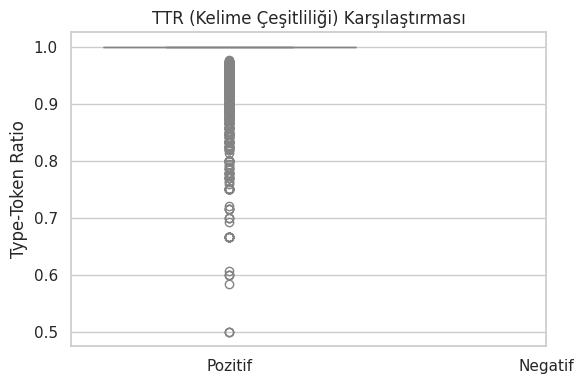

In [67]:
# TTR Boxplot: Pozitif vs Negatif paylaşımlarda kelime çeşitliliği farkına bakalım
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(data=[pozitif_TTR, negatif_TTR], palette="coolwarm")
plt.xticks([0, 1], ['Pozitif', 'Negatif'])
plt.title("TTR (Kelime Çeşitliliği) Karşılaştırması")
plt.ylabel("Type-Token Ratio")
plt.tight_layout()
plt.show()


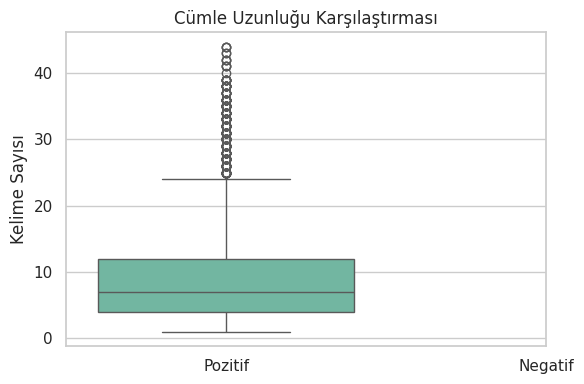

In [68]:
# Cümle uzunluğu karşılaştırması
plt.figure(figsize=(6, 4))
sns.boxplot(data=[pozitif_len, negatif_len], palette="Set2")
plt.xticks([0, 1], ['Pozitif', 'Negatif'])
plt.title("Cümle Uzunluğu Karşılaştırması")
plt.ylabel("Kelime Sayısı")
plt.tight_layout()
plt.show()


<ipython-input-69-ded6d5076b22>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kategori_sayim.values, y=kategori_sayim.index, palette="flare")


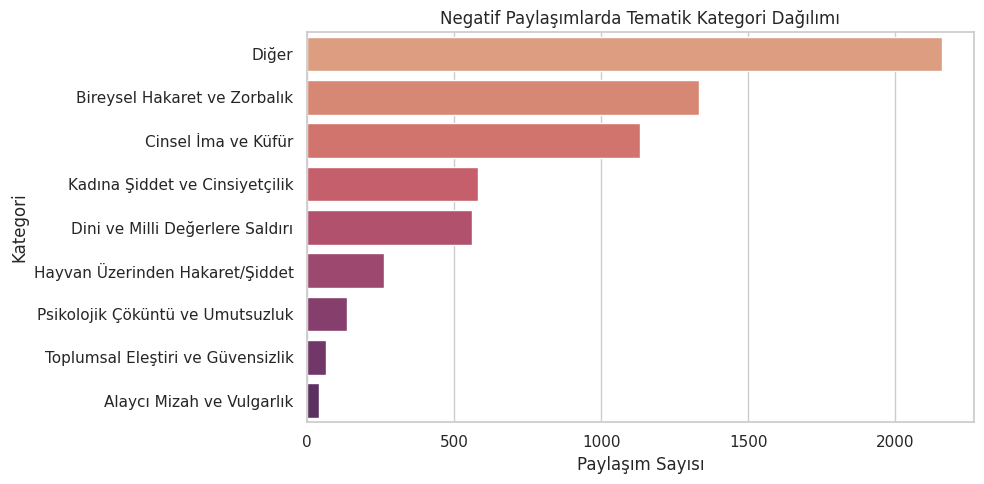

In [69]:
# Negatif paylaşımların tematik dağılımı
plt.figure(figsize=(10, 5))
sns.barplot(x=kategori_sayim.values, y=kategori_sayim.index, palette="flare")
plt.title("Negatif Paylaşımlarda Tematik Kategori Dağılımı")
plt.xlabel("Paylaşım Sayısı")
plt.ylabel("Kategori")
plt.tight_layout()
plt.show()


<ipython-input-70-b2a8d6f5d1db>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='rocket')


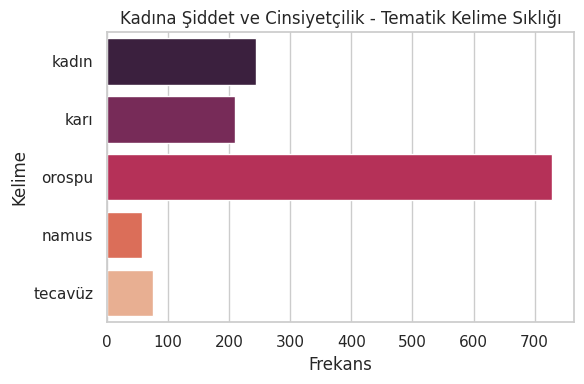

In [70]:
# Kadına Şiddet temalı önemli kelimelerin frekansı
kelimeler = ['kadın', 'karı', 'orospu', 'namus', 'tecavüz']
frekanslar = [kategori_df['Paylaşım'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='rocket')
plt.title("Kadına Şiddet ve Cinsiyetçilik - Tematik Kelime Sıklığı")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


<ipython-input-78-b29690c6b268>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='crest')


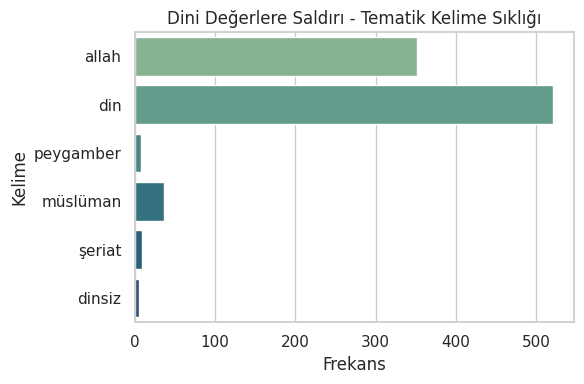

In [78]:
# Dini Değerlere Saldırı temalı önemli kelimelerin frekansı
kelimeler = ['allah', 'din', 'peygamber', 'müslüman', 'şeriat', 'dinsiz']
frekanslar = [kategori_df['Paylaşım'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='crest')
plt.title("Dini Değerlere Saldırı - Tematik Kelime Sıklığı")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


<ipython-input-79-8090359232aa>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='flare')


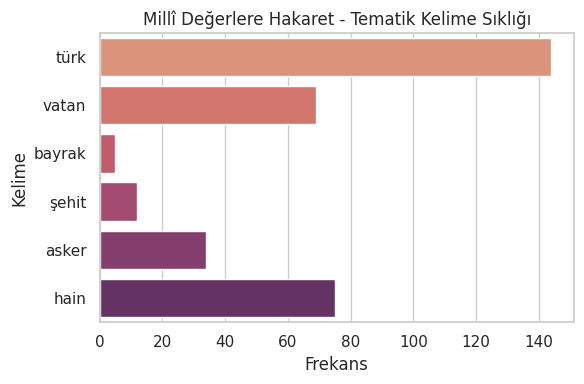

In [79]:
# Milli Değerlere Hakaret temalı önemli kelimelerin frekansı
kelimeler = ['türk', 'vatan', 'bayrak', 'şehit', 'asker', 'hain']
frekanslar = [kategori_df['Paylaşım'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='flare')
plt.title("Millî Değerlere Hakaret - Tematik Kelime Sıklığı")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


<ipython-input-82-8b8c01666d92>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='mako')


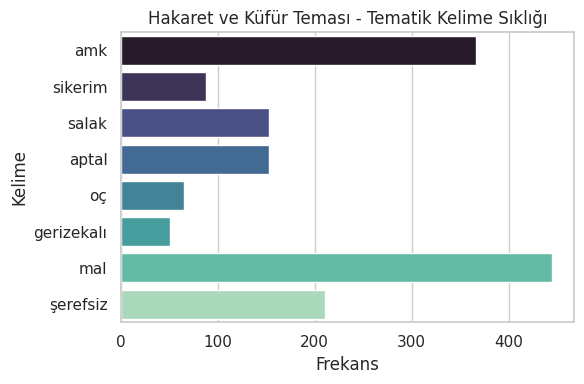

In [82]:
# Hakaret ve Küfür temalı önemli kelimelerin frekansı
kelimeler = ['amk', 'sikerim', 'salak', 'aptal', 'oç', 'gerizekalı', 'mal', 'şerefsiz']
frekanslar = [kategori_df['Paylaşım'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='mako')
plt.title("Hakaret ve Küfür Teması - Tematik Kelime Sıklığı")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


<ipython-input-83-cc64b35bbce0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='dark')


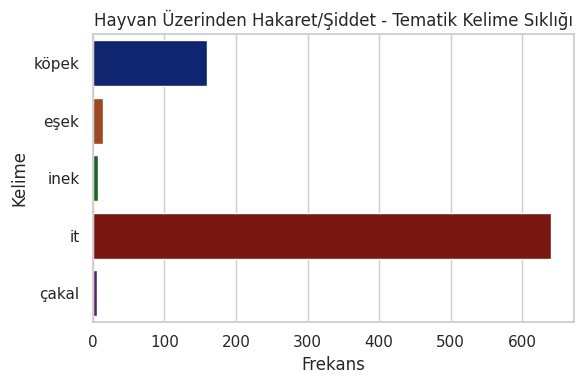

In [83]:
# Hayvan Üzerinden Hakaret/Şiddet temalı önemli kelimelerin frekansı
kelimeler = ['köpek', 'eşek', 'inek', 'it', 'çakal']
frekanslar = [kategori_df['Paylaşım'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='dark')
plt.title("Hayvan Üzerinden Hakaret/Şiddet - Tematik Kelime Sıklığı")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


<ipython-input-84-0202c31e8ee8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='ch:s=-.2,r=.6')


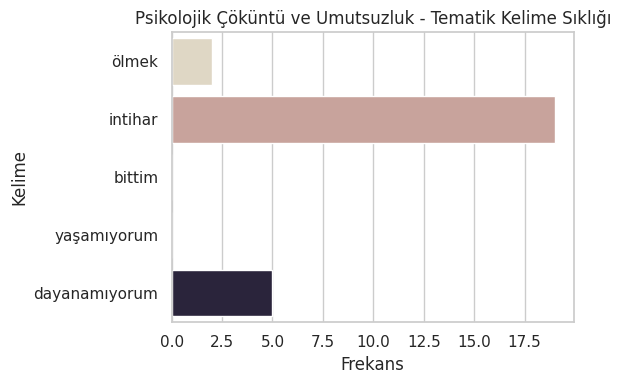

In [84]:
# Psikolojik Çöküntü temalı önemli kelimelerin frekansı
kelimeler = ['ölmek', 'intihar', 'bittim', 'yaşamıyorum', 'dayanamıyorum']
frekanslar = [kategori_df['Paylaşım'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='ch:s=-.2,r=.6')
plt.title("Psikolojik Çöküntü ve Umutsuzluk - Tematik Kelime Sıklığı")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


<ipython-input-85-cfdabd0ea527>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='husl')


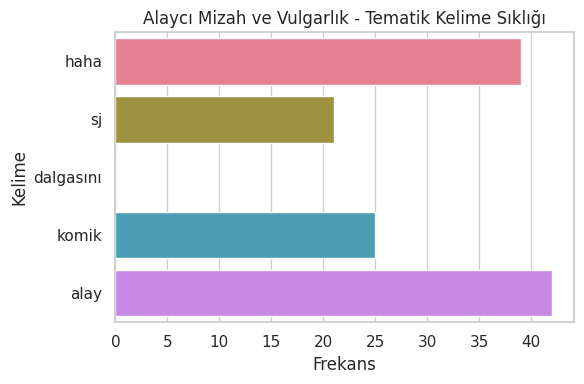

In [85]:
# Alay temalı önemli kelimelerin frekansı
kelimeler = ['haha', 'sj', 'dalgasını', 'komik', 'alay']
frekanslar = [kategori_df['Paylaşım'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='husl')
plt.title("Alaycı Mizah ve Vulgarlık - Tematik Kelime Sıklığı")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


In [71]:
# En yoğun kategori nedir?
en_yogun_kategori = kategori_sayim.idxmax()
en_yogun_sayi = kategori_sayim.max()

print(f"En yoğun kategori: '{en_yogun_kategori}' ({en_yogun_sayi} paylaşım)")


En yoğun kategori: 'Diğer' (2159 paylaşım)


In [72]:
# 🔍 Siber Zorbalık Tespiti
# Bu bölümde, daha önce tanımlanan tematik kategorilerden özellikle bireysel hakaret, cinsel küfür,
# kadına yönelik şiddet ve dini değerlere saldırı gibi içerikler 'siber zorbalık' kapsamında etiketlenecektir.
# Kategorilere göre içerikler filtrelenerek 'Zorbalık Var' veya 'Yok' olarak işaretlenecektir.

In [73]:
# Hangi kategoriler siber zorbalık olarak kabul edilecek
zorbalik_kategorileri = [
    'Bireysel Hakaret ve Zorbalık',
    'Cinsel İma ve Küfür',
    'Kadına Şiddet ve Cinsiyetçilik',
    'Dini ve Milli Değerlere Saldırı'
]

# Yeni sütun: Zorbalık içeriyor mu?
kategori_df['SiberZorbalik'] = kategori_df['Kategoriler'].apply(lambda x: 'Zorbalık Var' if x in zorbalik_kategorileri else 'Yok')

# Özet tablo: Kaç paylaşımda zorbalık var?
zorbalik_ozet = kategori_df['SiberZorbalik'].value_counts()
print(zorbalik_ozet)


SiberZorbalik
Zorbalık Var    3605
Yok             2668
Name: count, dtype: int64


<ipython-input-74-a25320f34b2b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=kategori_df, x='SiberZorbalik', palette='coolwarm')


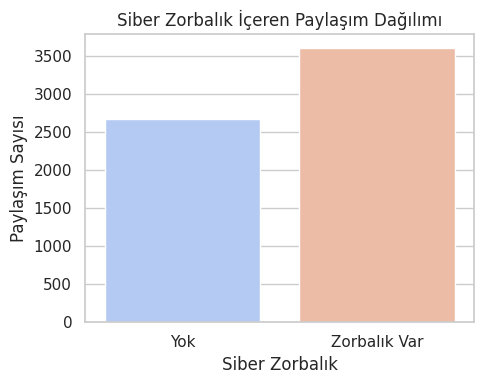

In [74]:
# Siber zorbalık dağılımının görselleştirilmesini yapalım
plt.figure(figsize=(5, 4))
sns.countplot(data=kategori_df, x='SiberZorbalik', palette='coolwarm')
plt.title("Siber Zorbalık İçeren Paylaşım Dağılımı")
plt.xlabel("Siber Zorbalık")
plt.ylabel("Paylaşım Sayısı")
plt.tight_layout()
plt.show()
